In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
import queue
from kafka import KafkaConsumer

import time, threading
import sys
sys.path.insert(0, 'C:/Users/Bin/Desktop/Thesis/code')
from EncDecAD_Pred import EncDecAD_Pred


In [2]:

batch_num =20
step_num = 20

consumer = KafkaConsumer('kdd99stream',
                         group_id='test-consumer-group',    # defined in consumer.properties file
                         bootstrap_servers=['localhost:9092'],
                         auto_offset_reset = "earliest")
consumer.poll()
#go to end of the stream
consumer.seek_to_end()
dataframe = pd.DataFrame()
lock = threading.Lock()

In [ ]:
def block_generator2queue(q,stop_event):
   
    while not stop_event.is_set():
        block = []
        
        for message in consumer:
            if stop_event.is_set():
                break
            row = message.value.decode("utf-8") 
            list_of_str = row.strip(",null,null,null,null,null,null,null,null").split(",")
            list_of_num = [float(n) for n in list_of_str]
            block.append(list_of_num)
            if len(block)==batch_num*step_num:
                df = pd.DataFrame(np.array(block))
                q.put(df)
                #print("Wrote a block to queue.")
                block.clear()

def read_block_from_queue(q,stop_event):
    global dataframe
    
    while not stop_event.is_set():
        if q.empty() == False:
            b = q.get()
            #print("read a block from queue")
            if dataframe.size == 0:
                dataframe = b
            else:
                pd.concat((dataframe,b),axis=0)
                
        else :
            time.sleep(0.5)
            
def prediction(stop_event):
    global dataframe
    pred = EncDecAD_Pred()
    while not stop_event.is_set():
        if dataframe.size == 0:
            print("Currently not enough data for prediction.")
            time.sleep(15)
        else:
            lock.acquire()
            try:
                print("Making prediction...")
                pred.prediction(dataframe.iloc[:,:-1],dataframe.iloc[:,-1])
                print("Finish prediction.")
            finally:
                dataframe = pd.DataFrame()
                lock.release()
            
def main():
    q = queue.Queue()
    stop_event = threading.Event()
   
    
    
    
    write = threading.Thread(target=block_generator2queue, name='WriteThread',args=(q,stop_event,))
    read = threading.Thread(target=read_block_from_queue, name='ReadThread',args=(q,stop_event,))
    predict = threading.Thread(target=prediction, name='prediction',args=(stop_event,))
   
    try:
        write.start()
        read.start()
        predict.start()
        
        while 1:
            time.sleep(.1)
    except (KeyboardInterrupt,SystemExit):
        stop_event.set()
        print("Threads closed.")

Currently not enough data for prediction.
Currently not enough data for prediction.
Making prediction...
INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/52test/LSTMAutoencoder_kdd99_v1_para.ckpt
LSTMs-Autoencoder Model imported.
Predict result :


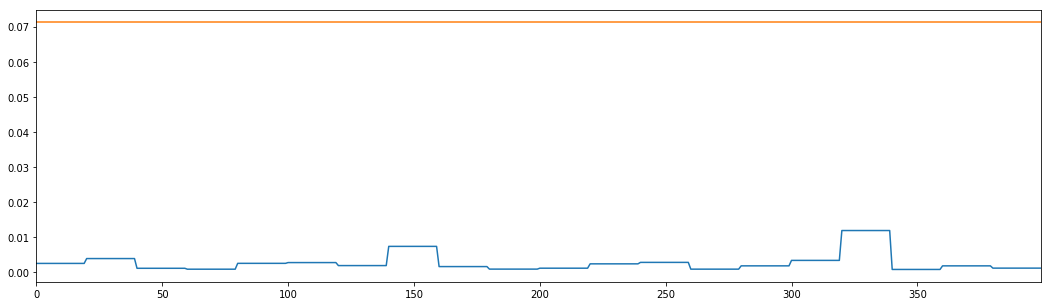

C:/Users/Bin/Desktop/Thesis/code\EncDecAD_Pred.py:94: RuntimeWarning: invalid value encountered in longlong_scalars
  P = tp/(tp+fp)
C:/Users/Bin/Desktop/Thesis/code\EncDecAD_Pred.py:95: RuntimeWarning: invalid value encountered in longlong_scalars
  R = tp/(tp+fn)


tp: 0,fp: 0,tn: 400,fn: 0,
P: nan,R: nan
Fbeta: nan
Finish prediction.
Currently not enough data for prediction.
Making prediction...
INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/52test/LSTMAutoencoder_kdd99_v1_para.ckpt
LSTMs-Autoencoder Model imported.
Predict result :


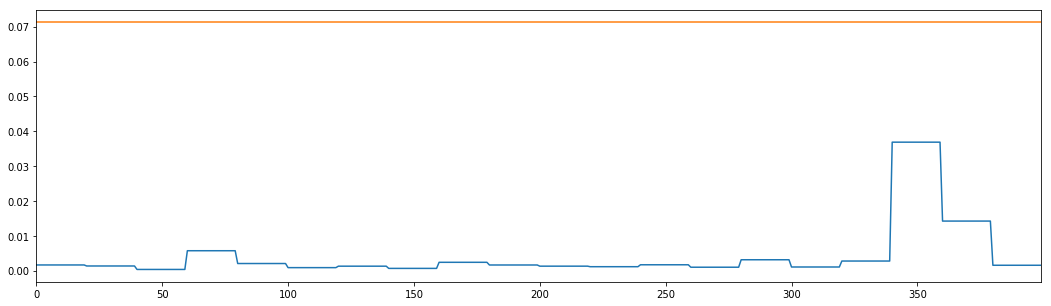

tp: 0,fp: 0,tn: 400,fn: 0,
P: nan,R: nan
Fbeta: nan
Finish prediction.
Currently not enough data for prediction.
Making prediction...
INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/52test/LSTMAutoencoder_kdd99_v1_para.ckpt
LSTMs-Autoencoder Model imported.
Predict result :


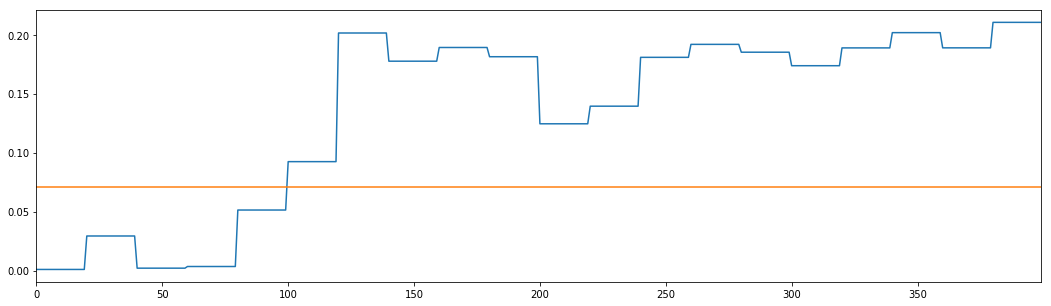

tp: 0,fp: 300,tn: 100,fn: 0,
P: 0.000,R: nan
Fbeta: nan
Finish prediction.
Currently not enough data for prediction.
Making prediction...


In [ ]:
if __name__=="__main__":
    main()